### Imports

In [1]:
import os
import pandas as pd
import warnings
from PIL import Image

warnings.filterwarnings('ignore')

### Load data

In [2]:
os.chdir('..')

In [3]:
# 'test_results'
experiment_name = input('Provide the name of the experiment folder')

In [4]:
evaluation_file = f'data/results/{experiment_name}/evaluation.tsv'

In [5]:
results = pd.read_csv(evaluation_file, sep='\t')

In [7]:
results.head()

,prompt_id,image_id,clip_score,user_prompt,optimized_prompt,caption,image_path,img_sim_score,spice_score,best_image,terminated
0,0,0,0.779375,A couple of middle eastern dishes with fruit a...,A couple of middle eastern dishes with fruit a...,a close up of a table with bowls of food and b...,/home/lcur1713/SocraticImageGeneration/data/re...,0.549753,0.000000,0.0,0.0
1,0,1,0.765068,A couple of middle eastern dishes with fruit a...,A flavorful spread of Middle Eastern mezze dis...,a close up of a table with bowls of food and a...,/home/lcur1713/SocraticImageGeneration/data/re...,0.598717,0.105263,0.0,0.0
2,0,2,0.786328,A couple of middle eastern dishes with fruit a...,A platter of middle eastern cuisine served wit...,there are four bowls of food on a table with s...,/home/lcur1713/SocraticImageGeneration/data/re...,0.614786,0.000000,0.0,0.0
3,0,3,0.752815,A couple of middle eastern dishes with fruit a...,A spread of Middle Eastern cuisine featuring a...,a close up of a table with bowls of food and b...,/home/lcur1713/SocraticImageGeneration/data/re...,0.555429,0.111111,1.0,0.0
4,0,4,0.838345,A couple of middle eastern dishes with fruit a...,Middle Eastern mezze spread with tabbouleh sal...,there are many different types of food on the ...,/home/lcur1713/SocraticImageGeneration/data/re...,0.600402,0.000000,0.0,0.0


In [8]:
# Define columns with scores
scores = ['clip_score','spice_score','img_sim_score']

### Results

In [9]:
#prompt_num = results['prompt_id'].nunique()
#optimization_step_num = results.groupby(['prompt_id'])['image_id'].count().max()
results.columns

Index(['prompt_id', 'image_id', 'clip_score', 'user_prompt',
       'optimized_prompt', 'caption', 'image_path', 'img_sim_score',
       'spice_score', 'best_image', 'terminated'],
      dtype='object')

#### Percentage of generated image better than the initial one (works only for COCO dataset)

In [27]:
df = results[['image_id','clip_score','terminated']]
num_better_score_than_initial = 0
# for every original image (6,13,20..)
for i in range(6, len(df), 7):
    terminated = False
    # check all the generated images (0..5, 7..12,...)
    for j in range(i-1,i-7,-1):
        if df.loc[j,'terminated']==1:
            terminated = True
        # if it was terminated and the score was higher than the initial increase the counter
        if df.loc[j,'terminated']==1 and df.loc[i, "image_id"] == -1 and df.loc[j, "clip_score"] >= df.loc[i, "clip_score"]:
           num_better_score_than_initial +=1

    # It can be the case that it wasn't terminated and thus we chose the last image (5th iteration)
    # then check if the last image has better result than the initial one
    if not terminated and df.loc[i, "image_id"] == -1 and df.loc[i-1, "clip_score"] >= df.loc[i, "clip_score"]:
        num_better_score_than_initial += 1
num_prompts = len(df)/7
print("The clip score at the terminated step was better than the initial", (num_better_score_than_initial/num_prompts)*100, "% of the times")

The clip score at the terminated step was better than the initial 60.0 % of the times


#### Average scores

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
scores_w_id = scores.copy()
scores_w_id.append('image_id')
coco = True
if 'img_sim_score' not in results.columns:
    coco = False
    scores_w_id.remove('img_sim_score')

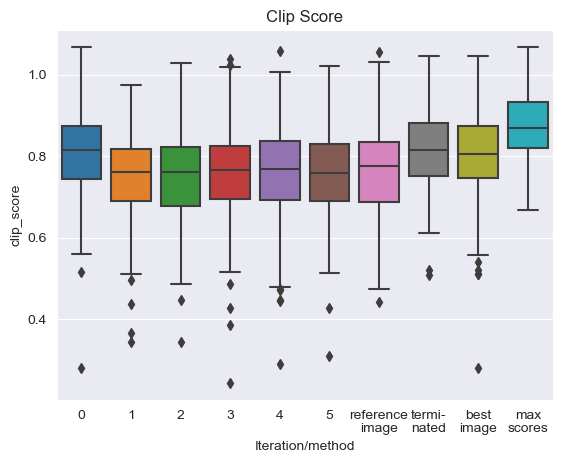

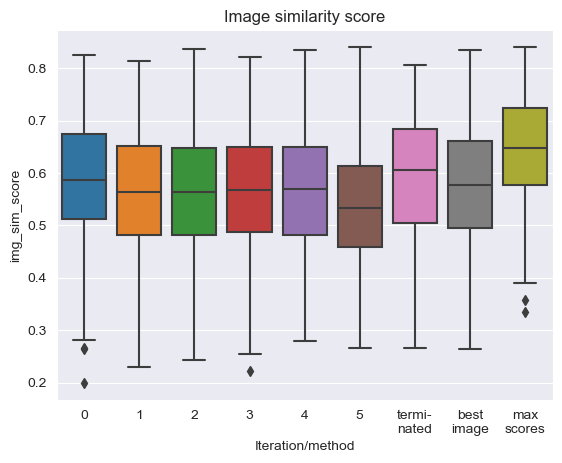

In [13]:
df = results[scores_w_id]
df_terminated = results[results['terminated'] == True][scores_w_id]
df_terminated['image_id'] = 'termi-\nnated'
df_best_image =  results[results['best_image'] == True][scores_w_id]
df_best_image['image_id'] = 'best\nimage'
df = df.append(df_terminated)
df = df.append(df_best_image)
df.loc[df['image_id']== -1, 'image_id']= 'reference\nimage'

max_clip = results.groupby(by='prompt_id')['clip_score'].max()
max_spice = results.groupby(by='prompt_id')['spice_score'].max()
max_scores = pd.merge(max_clip, max_spice, on='prompt_id', how='left')

# If it is the coco dataset then we have img_sim_score, otherwise we don't
if coco:
    max_img_sim = results.groupby(by='prompt_id')['img_sim_score'].max()
    max_scores = pd.merge(max_scores, max_img_sim, on='prompt_id', how='left')


max_scores['image_id']='max\nscores'
df = df.append(max_scores)

# clip scores
columns_clip = ['image_id','clip_score']
sns.boxplot(x='image_id', y='clip_score', data=df[columns_clip])
plt.xlabel('Iteration/method')
plt.title("Clip Score")
plt.show()

# spice score
# filtered_df = df[df['image_id'] != 'reference\nimage' ]
# columns_spice = ['image_id','spice_score']
# sns.boxplot(x='image_id', y='spice_score', data=filtered_df[columns_spice])
# plt.title("Spice Score boxplot for each Iteration")
# plt.show()

# If it is the coco dataset then we have img_sim_score, otherwise we don't
if coco:
    filtered_df = df[df['image_id'] != 'reference\nimage' ]
    columns_img_sim = ['image_id','img_sim_score']
    sns.boxplot(x='image_id', y='img_sim_score', data=filtered_df[columns_img_sim])
    plt.xlabel('Iteration/method')
    plt.title("Image similarity score")
    plt.show()

In [14]:
# Average scores for all prompts
results[scores].mean()

clip_score       0.764672
spice_score      0.249833
img_sim_score    0.563663
dtype: float64

#### Average scores per prompt

In [15]:
# Average scores per prompt
results.groupby(['prompt_id','user_prompt'])[scores].mean()

,,clip_score,spice_score,img_sim_score
prompt_id,user_prompt,,,
0,A couple of middle eastern dishes with fruit and herbs.,0.776064,0.036062,0.574663
1,Full course dinner served on large plate including drinks and dessert.,0.733332,0.131645,0.506301
2,This room is decorated in a simple yet elegant style.,0.646139,0.086247,0.525059
3,A man carrying a large US flag on a horse riding down a town street,0.906635,0.352338,0.561215
4,A woman with a braid holds her dog in her lap.,0.703186,0.289114,0.459170
...,...,...,...,...
195,Sheep graze in a large field with trees behind them.,0.771189,0.199370,0.718297
196,there is a young boy eating a piece of cake,0.744687,0.327869,0.509339
197,Two toilets that are sitting on a tile floor.,0.794545,0.178571,0.587402


#### Early stopping

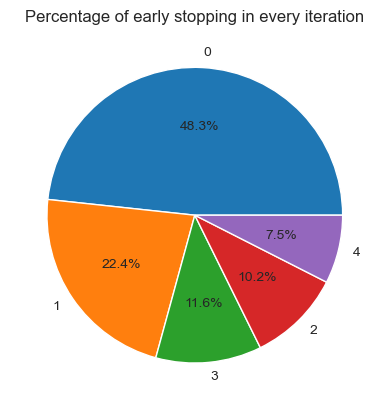

In [16]:
df = results[['image_id','terminated']]

filtered_df = df[df['terminated'] == 1]

# Count the occurrences of each value in the second column
grouped = filtered_df['image_id'].value_counts()

# Create a pie chart based on the counts
labels = grouped.index.tolist() # Get the unique values in the second column as labels
plt.pie(grouped, labels=labels, autopct='%1.1f%%')
plt.title("Percentage of early stopping in every iteration")
plt.show()


In [17]:
# Percentage of prompts that were stopped
results.groupby(['prompt_id'])['terminated'].max().mean()

0.735

In [18]:
# Most often terminations step based on best image
results[results['terminated'] == True]['image_id'].value_counts().sort_values(ascending=False)

0    71
1    33
3    17
2    15
4    11
Name: image_id, dtype: int64

In [19]:
# Average termination step for based image
results[results['terminated'] == True]['image_id'].mean()

1.0748299319727892

In [20]:
# Average scores for stopped prompts
results[results['terminated'] == True][scores].mean()

clip_score       0.815444
spice_score      0.327987
img_sim_score    0.593408
dtype: float64

#### Best Image

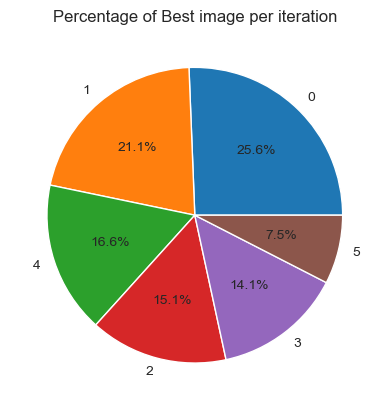

In [21]:
df = results[['image_id','best_image']]

filtered_df = df[df['best_image'] == 1]

# Count the occurrences of each value in the second column
grouped = filtered_df['image_id'].value_counts()

# Create a pie chart based on the counts
labels = grouped.index.tolist() # Get the unique values in the second column as labels
plt.pie(grouped, labels=labels, autopct='%1.1f%%')
plt.title("Percentage of Best image per iteration")
plt.show()


In [22]:
# Most often terminations step based on best image
results[results['best_image'] == True]['image_id'].value_counts().sort_values(ascending=False)

0    51
1    42
4    33
2    30
3    28
5    15
Name: image_id, dtype: int64

In [23]:
# Average termination step for based image
results[results['best_image'] == True]['image_id'].mean()

1.9748743718592965

In [24]:
# Average scores for best image
results[results['best_image'] == True][scores].mean()

clip_score       0.798738
spice_score      0.310403
img_sim_score    0.575858
dtype: float64

In [ ]:
prompt_id = int(input("Provide prompt_id"))
for idx, row in results[results['prompt_id'] == prompt_id].reset_index().iterrows():
    print('Iteration:', idx + 1)
    if row['terminated'] == 1:
        print('TERMINATED at this step')
    if row['best_image'] == 1:
        print('BEST IMAGE according to LLM')
    if idx == 0:
        print('Original prompt:', row['optimized_prompt'])
    else:
        print('Optimized prompt:', row['optimized_prompt'])
    print('Generated image:')
    image = Image.open(row['image_path'])
    display(image)
    print('Caption:', row['caption'])
    print('#################################################################################')